In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

ip_map = {
    "45.77.229.242": "GB-London",
    "62.154.179.86": "DE-Berlin",
    "194.156.155.241": "ES-Madrid",
    "194.230.35.117": "CH-Zurich",
    # "193.46.104.17": "AT-Vienna", #should be .17 but error
    "193.46.104.12": "AT-Vienna",
    "185.32.189.249": "PT-Lisbon",
    "213.135.49.134": "PL-Warsaw",
    "51.159.68.135": "FR-Paris",
    "185.78.84.3": "TR-Istanbul",
    "185.157.208.248": "GR-Athens"
}

In [125]:
import geopandas as gpd

cities = {
    "GB-London": (-0.0695, 51.5185),
    "DE-Berlin": (13.4205, 52.5495),
    "ES-Madrid": (-3.6215, 40.4405),
    "CH-Zurich": (8.5605, 47.4185),
    "AT-Vienna": (16.4075, 48.2715),
    "PT-Lisbon": (-9.1215, 38.7915),
    "PL-Warsaw": (20.9375, 52.2515),
    "FR-Paris": (2.4075, 48.7905),
    "TR-Istanbul": (28.8305, 40.9915),
    "GR-Athens": (23.7705, 38.0695)
}

df = pd.DataFrame([
    {"city": name, "lon": coord[0], "lat": coord[1]}
    for name, coord in cities.items()
])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['lon'], df['lat']),
    crs="EPSG:4326"
)

gdf = gdf.to_crs("EPSG:3857")

dist_rows = []
for src_city, dst_city in product(gdf['city'], repeat=2):
    src_geom = gdf[gdf['city'] == src_city].geometry.values[0]
    dst_geom = gdf[gdf['city'] == dst_city].geometry.values[0]
    
    dist_km = src_geom.distance(dst_geom) / 1000
    
    dist_rows.append({
        "src": src_city,
        "dst": dst_city,
        "distance_km": dist_km
    })
dist_df = pd.DataFrame(dist_rows)

In [126]:
trace_df = pd.read_csv("data/full/traceroute.csv")

trace_df['src'] = trace_df['src_addr'].map(ip_map)
trace_df['dst'] = trace_df['dst_addr'].map(ip_map)

trace_df['timestamp'] = pd.to_datetime(trace_df['timestamp'], unit='s')
trace_df = trace_df.sort_values('msm_id')

# http_df['pair'] = http_df['src'] + " - " + http_df['dst']

print(trace_df)

           msm_id         src_addr       dst_addr  hop  sent  received  \
329420  136909065  185.157.208.248  51.159.68.135    7     3         3   
320612  136909065  185.157.208.248  51.159.68.135    5     3         3   
320611  136909065  185.157.208.248  51.159.68.135    4     3         3   
320610  136909065  185.157.208.248  51.159.68.135    3     3         3   
320609  136909065  185.157.208.248  51.159.68.135    2     3         0   
...           ...              ...            ...  ...   ...       ...   
32912   136909083  194.156.155.241  62.154.179.86    6     3         3   
32911   136909083  194.156.155.241  62.154.179.86    5     3         0   
32910   136909083  194.156.155.241  62.154.179.86    4     3         3   
32980   136909083   213.135.49.134  62.154.179.86    2     3         1   
0       136909083   194.230.35.117  62.154.179.86    1     3         3   

           min        avg     max            from  timed_out  \
329420  58.329  58.399998  58.474   51.159.68.1

In [127]:
final_hops = (
    trace_df.sort_values('hop')
            .groupby(['src_addr', 'dst_addr', 'timestamp'])
            .tail(1)
)
print(final_hops)

           msm_id        src_addr         dst_addr  hop  sent  received  \
79513   136909080  185.32.189.249  194.156.155.241    4     3         3   
55451   136909080  185.32.189.249  194.156.155.241    4     3         3   
79455   136909080  185.32.189.249  194.156.155.241    4     3         3   
64673   136909080  185.32.189.249  194.156.155.241    4     3         3   
66529   136909080  185.32.189.249  194.156.155.241    4     3         3   
...           ...             ...              ...  ...   ...       ...   
200114  136909069  213.135.49.134    193.46.104.12  255     3         0   
91061   136909078     185.78.84.3   194.230.35.117  255     3         0   
325503  136909065     185.78.84.3    51.159.68.135  255     3         0   
282368  136909067     185.78.84.3    45.77.229.242  255     3         0   
175596  136909069   51.159.68.135    193.46.104.12  255     3         0   

           min        avg     max             from  timed_out  \
79513    9.151  13.775666  18.736 

In [128]:
trace_errors_df = final_hops[final_hops['destination_ip_responded'] == False]
trace_good_df   = final_hops[final_hops['destination_ip_responded'] == True]

trace_good_swapped = trace_good_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
trace_good_symmetric = pd.concat([trace_good_df, trace_good_swapped], ignore_index=True)

trace_errors_swapped = trace_errors_df.rename(columns={'src_addr':'dst_addr', 'dst_addr':'src_addr', 'src':'dst', 'dst':'src'})
trace_errors_symmetric = pd.concat([trace_errors_df, trace_errors_swapped], ignore_index=True)

agg_trace_good = trace_good_symmetric.groupby(['src', 'dst'])['avg'].mean().reset_index()
agg_trace_errors = trace_errors_symmetric.groupby(['src', 'dst'])['timed_out'].count().reset_index()

all_names = sorted([x for x in ip_map.values()])
full_pairs = pd.DataFrame(list(product(all_names, all_names)), columns=['src', 'dst'])
full_pairs = full_pairs.merge(dist_df, on=['src', 'dst'], how='left')

merged_good = full_pairs.merge(agg_trace_good, on=['src','dst'], how='left')
merged_good['ping_per_km'] = merged_good['avg'] / merged_good['distance_km'] * 1000
merged_good = merged_good.fillna(0).pivot(index='src', columns='dst', values='ping_per_km')

trace_good_heatmap_data = pd.merge(full_pairs, agg_trace_good, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='avg')
trace_errors_heatmap_data = pd.merge(full_pairs, agg_trace_errors, on=['src', 'dst'], how='left').fillna(0).pivot(index='src', columns='dst', values='timed_out')

In [129]:
print(agg_trace_good[(agg_trace_good['src'] == "TR-Istanbul") & (agg_trace_good['avg'] > 0.0)])

            src        dst        avg
57  TR-Istanbul  GR-Athens  52.267748


Text(70.72222222222221, 0.5, 'Source Address')

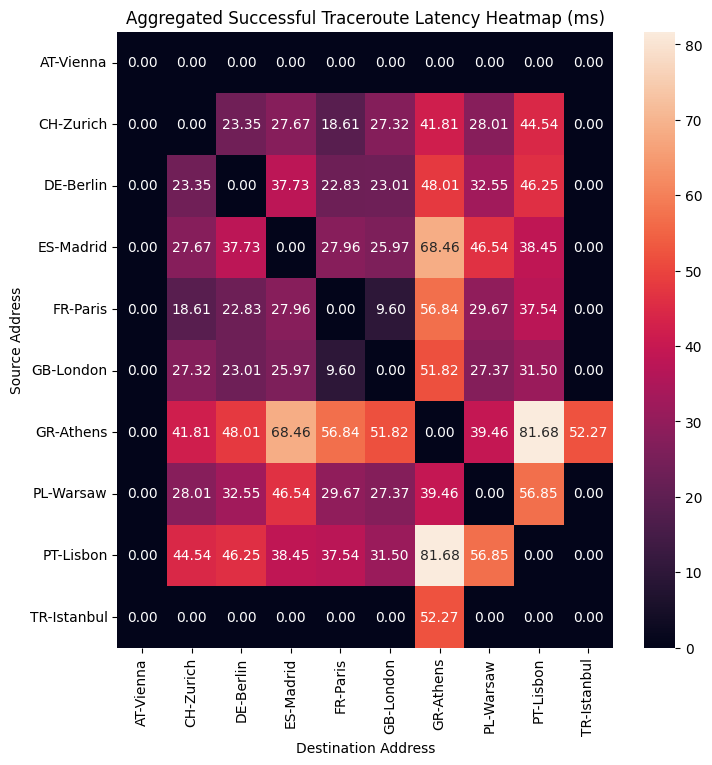

In [130]:
plt.figure(figsize=(8,8))
sns.heatmap(trace_good_heatmap_data, annot=True, fmt="0.2f", cmap="rocket")
plt.title("Aggregated Successful Traceroute Latency Heatmap (ms)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

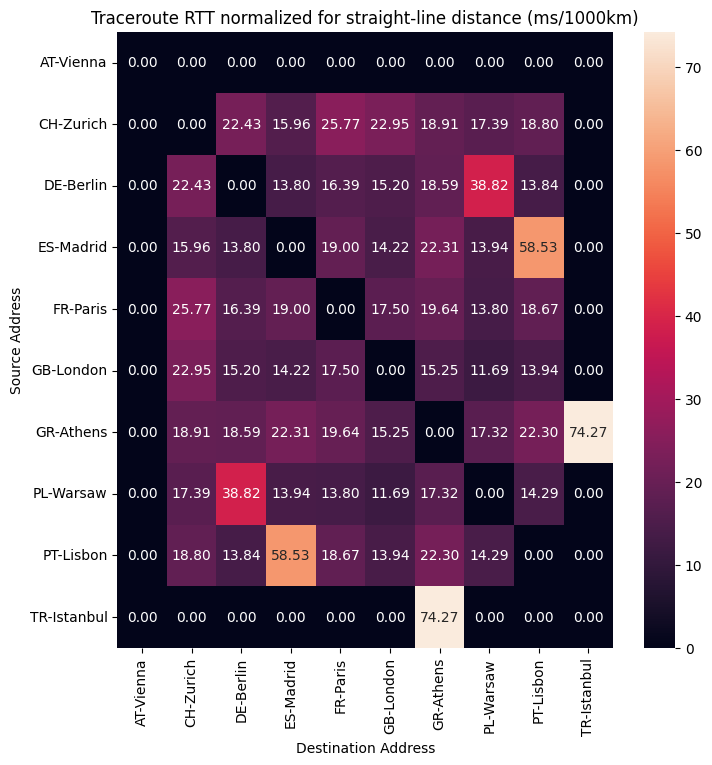

In [131]:
plt.figure(figsize=(8,8))
sns.heatmap(merged_good, annot=True, fmt="0.2f", cmap="rocket")
plt.title("Traceroute RTT normalized for straight-line distance (ms/1000km)")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")

Text(70.72222222222221, 0.5, 'Source Address')

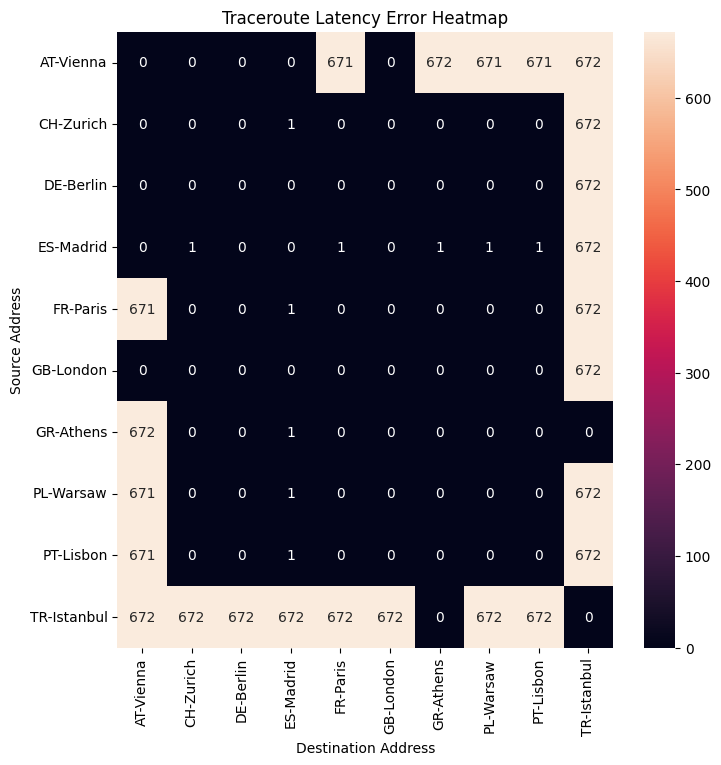

In [132]:
plt.figure(figsize=(8,8))
sns.heatmap(trace_errors_heatmap_data, fmt="0.0f", annot=True, cmap="rocket")
plt.title("Traceroute Latency Error Heatmap")
plt.xlabel("Destination Address")
plt.ylabel("Source Address")